<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/severstal_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import pickle

import time 

In [0]:
sz = (1600, 256) #size of input images
sz0 = 256
# MASKS = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/train.csv'
# IMAGES = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/images/train_images/'          #test or train

def enc2mask(encs, shape=(1600,256)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

In [0]:
df_masks = pd.read_csv(MASKS)
split_df = df_masks['ImageId_ClassId'].str.split('_', n=1, expand=True)
df_masks['Image'] = split_df[0]
normal_data = []
multi = []
for image_code in tqdm(df_masks.Image.unique()):
    if df_masks.groupby(['Image']).EncodedPixels.count().loc[image_code] == 0:
        normal_data.append(image_code)
    elif df_masks.groupby(['Image']).EncodedPixels.count().loc[image_code] > 1:
        multi.append(image_code)

100%|██████████| 12568/12568 [04:14<00:00, 49.30it/s]


In [0]:
len(normal_data)

5902

In [0]:
len(multi)

427

In [0]:
df_masks = pd.read_csv(MASKS)
df_masks['id'] = [id[:-2] for id in df_masks.ImageId_ClassId]
df_masks = pd.DataFrame(df_masks.groupby('id')['EncodedPixels'].apply(list))

fnames = os.listdir(IMAGES)
n_crops = 6
offsets = [32 + sz0*i for i in range(n_crops)]

In [0]:
offsets

[32, 288, 544, 800, 1056, 1312]

In [0]:
df_masks

,EncodedPixels
id,
0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...
00031f466.jpg,"[nan, nan, nan, nan]"
000418bfc.jpg,"[nan, nan, nan, nan]"
000789191.jpg,"[nan, nan, nan, nan]"
0007a71bf.jpg,"[nan, nan, 18661 28 18863 82 19091 110 19347 1..."
...,...
fff0295e1.jpg,"[nan, nan, nan, nan]"
fff02e9c5.jpg,"[nan, nan, 207523 3 207777 9 208030 15 208283 ..."
fffe98443.jpg,"[nan, nan, 105929 5 106177 14 106424 24 106672..."


In [0]:
len(fnames)

12568

In [0]:
datadict = dict()
datadict['0'] = []
datadict['1'] = []
datadict['2'] = []
datadict['3'] = []
datadict['4'] = []
f = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/black_image.txt', 'w')
count = 0
for fname in tqdm(fnames[:160]):
    if '.jpg' not in fname:
        continue
    img0 = Image.open(os.path.join(IMAGES, fname))
    img0 = np.asarray(img0)
    if fname in normal_data:
        normal_data.remove(fname)
        r = np.random.randint(0,n_crops)
        img = img0[:, offsets[r] : offsets[r]+sz0, :]
        if img.mean() < 5 and img.std() < 5:
            f.write(fname+'\n')
            count += 1
            continue
        img = img.reshape([sz0*sz0*3])
        datadict['0'].append(img)
        continue
    elif fname in multi:
        continue
        
    mask0 = enc2mask(df_masks.loc[fname].EncodedPixels)
    
    for i in range(n_crops):
        img = img0[:, offsets[i] : offsets[i]+sz0, :]
        if img.mean() < 5 and img.std() < 5:
            f.write(fname+'\n')
            count += 1
            continue
        img = img.reshape([sz0*sz0*3])
        mask = mask0[:, offsets[i]:offsets[i]+sz0]
        lab = []
        for v in range(1,5):
            lab.append(list(mask.flat).count(v))
        if mask.max() == 0:
            datadict['0'].append(img)
        else:
            datadict[str(np.argmax(lab)+1)].append(img)
f.write(str(count))
f.close() 


# #additional
# train_dict = dict()
# test_dict = dict()
# for k,v in datadict.items():
#     num_data = len(v)
#     global_idx = np.arange(num_data)
#     np.random.shuffle(global_idx)
#     train_idx = global_idx[:int(num_data*0.7)]
#     test_idx = global_idx[int(num_data*0.7):]
#     train_dict[k] = np.array(v)[train_idx]
#     test_dict[k] = np.array(v)[test_idx]


# train = dict()
# test = dict()
# train['data'] = []
# train['label'] = []
# test['data'] = []
# test['label'] = []

# for k,v in train_dict.items():
#     for img in v:
#         train['data'].append(img)
#         train['label'].append(int(k))
# train['data'] = np.array(train['data'])
# train['label'] = np.array(train['label'])

# for k,v in test_dict.items():
#     for img in v:
#         test['data'].append(img)
#         test['label'].append(int(k))
# test['data'] = np.array(test['data'])
# test['label'] = np.array(test['label'])

# # pickling the array
# train_file = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/train_uni', 'wb')
# pickle.dump(train, train_file, protocol=pickle.HIGHEST_PROTOCOL)
# train_file.close()
# test_file = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/test_uni', 'wb')
# pickle.dump(test, test_file, protocol=pickle.HIGHEST_PROTOCOL)
# test_file.close()

# info = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/uni_info.txt', 'w')
# s = '0: '+str(len(datadict['0']))+'\t1: '+str(len(datadict['1']))+'\t2: '+str(len(datadict['2']))+'\t3: '+str(len(datadict['3']))+'\t4: '+str(len(datadict['4']))
# info.write(s)
# info.close()

# _X = np.array(train['data'])
# _Y = np.array(train['label'])

# assert _X.shape[0] == _Y.shape[0]
# datadict = dict()
# for i in range(5):
#     datadict[str(i)]=[]

# for d, l in tqdm(zip(_X, _Y)):
#     datadict[str(l)].append(d)

# for k, v in tqdm(datadict.items()):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_'+ k
#     f = open(fname, 'wb')
#     pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()

# _X = np.array(test['data'])
# _Y = np.array(test['label'])

# assert _X.shape[0] == _Y.shape[0]
# datadict = dict()
# for i in range(5):
#     datadict[str(i)]=[]

# for d, l in tqdm(zip(_X, _Y)):
#     datadict[str(l)].append(d)

# for k, v in tqdm(datadict.items()):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_test_'+ k
#     f = open(fname, 'wb')
#     pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()

# chunk = dict()
# chunk['0']=8
# chunk['3']=3

# for i in range(5):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_'+ str(i)
#     f = open(fname, 'rb')
#     data = pickle.load(f)
#     f.close()
#     f = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/chunked_unilabel_train_'+ str(i), 'wb')
#     if i == 1 or i == 2 or i == 4:
#         print ('label ', i, 'has of length', data.shape[0])
#         pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()
#     else:
#         np.random.shuffle(data)
#         print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
#                data.shape[0]//chunk[str(i)]) 
#         pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()

# chunk = dict()
# chunk['0']=3

# for i in range(5):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_test_'+ str(i)
#     f = open(fname, 'rb')
#     data = pickle.load(f)
#     f.close()
#     f = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/chunked_unilabel_test_'+ str(i), 'wb')
#     if i != 0:
#         print ('label ', i, 'has of length', data.shape[0])
#         pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()
#     else:
#         np.random.shuffle(data)
#         print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
#                data.shape[0]//chunk[str(i)])
#         pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()



100%|██████████| 160/160 [03:56<00:00,  1.39s/it]


In [0]:
len(datadict['4'])

14

In [0]:
train_dict = dict()
test_dict = dict()
for k,v in datadict.items():
    num_data = len(v)
    global_idx = np.arange(num_data)
    np.random.shuffle(global_idx)
    train_idx = global_idx[:int(num_data*0.7)]
    test_idx = global_idx[int(num_data*0.7):]
    train_dict[k] = np.array(v)[train_idx]
    test_dict[k] = np.array(v)[test_idx]

In [0]:
len(v)

14

In [0]:
train_idx

array([ 0,  3,  6, 11,  8,  9, 13, 10,  5])

In [0]:
len(train_dict['4'])

9

In [0]:
train_dict['4']

array([[101, 101, 101, ..., 208, 208, 208],
       [105, 105, 105, ..., 209, 209, 209],
       [ 54,  54,  54, ...,  57,  57,  57],
       ...,
       [ 83,  83,  83, ...,  95,  95,  95],
       [ 63,  63,  63, ..., 118, 118, 118],
       [ 48,  48,  48, ...,  86,  86,  86]], dtype=uint8)

In [0]:
train = dict()
test = dict()
train['data'] = []
train['label'] = []
test['data'] = []
test['label'] = []

for k,v in train_dict.items():
    for img in v:
        train['data'].append(img)
        train['label'].append(int(k))
train['data'] = np.array(train['data'])
train['label'] = np.array(train['label'])

In [0]:
len(train['data'])

343

In [0]:
for k,v in test_dict.items():
    for img in v:
        test['data'].append(img)
        test['label'].append(int(k))
test['data'] = np.array(test['data'])
test['label'] = np.array(test['label'])

In [0]:
# pickling the array
train_file = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/train_uni', 'wb')
pickle.dump(train, train_file, protocol=pickle.HIGHEST_PROTOCOL)
train_file.close()
test_file = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/test_uni', 'wb')
pickle.dump(test, test_file, protocol=pickle.HIGHEST_PROTOCOL)
test_file.close()

In [0]:
info = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/uni_info.txt', 'w')
s = '0: '+str(len(datadict['0']))+'\t1: '+str(len(datadict['1']))+'\t2: '+str(len(datadict['2']))+'\t3: '+str(len(datadict['3']))+'\t4: '+str(len(datadict['4']))
info.write(s)
info.close()

In [0]:
_X = np.array(train['data'])
_Y = np.array(train['label'])

assert _X.shape[0] == _Y.shape[0]
datadict = dict()
for i in range(5):
    datadict[str(i)]=[]

for d, l in tqdm(zip(_X, _Y)):
    datadict[str(l)].append(d)

for k, v in tqdm(datadict.items()):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_train_'+ k
    f = open(fname, 'wb')
    pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

343it [00:00, 114880.32it/s]
100%|██████████| 5/5 [00:00<00:00,  9.85it/s]


In [0]:
_X = np.array(test['data'])
_Y = np.array(test['label'])

assert _X.shape[0] == _Y.shape[0]
datadict = dict()
for i in range(5):
    datadict[str(i)]=[]

for d, l in tqdm(zip(_X, _Y)):
    datadict[str(l)].append(d)

for k, v in tqdm(datadict.items()):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_test_'+ k
    f = open(fname, 'wb')
    pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

150it [00:00, 108305.32it/s]
100%|██████████| 5/5 [00:00<00:00, 34.67it/s]


In [0]:
chunk = dict()
chunk['0']=8
chunk['3']=3

for i in range(5):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_train_'+ str(i)
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    f = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/chunked_unilabel_train_'+ str(i), 'wb')
    if i == 1 or i == 2 or i == 4:
        print ('label ', i, 'has of length', data.shape[0])
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    else:
        np.random.shuffle(data)
        print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
               data.shape[0]//chunk[str(i)]) 
        pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

label  0 has of length 201 chunk to  25
label  1 has of length 17
label  2 has of length 2
label  3 has of length 114 chunk to  38
label  4 has of length 9


In [0]:
chunk = dict()
chunk['0']=3

for i in range(5):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_test_'+ str(i)
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    f = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/chunked_unilabel_test_'+ str(i), 'wb')
    if i != 0:
        print ('label ', i, 'has of length', data.shape[0])
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    else:
        np.random.shuffle(data)
        print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
               data.shape[0]//chunk[str(i)])
        pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

label  0 has of length 87 chunk to  29
label  1 has of length 8
label  2 has of length 1
label  3 has of length 49
label  4 has of length 5


Play

In [0]:
#play

file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/train_uni'
f = open(file_name , 'rb')
pickle_data = pickle.load(f)
f.close()

In [0]:
print(type(pickle_data))

<class 'dict'>


In [0]:
len(pickle_data['data'])

26839

In [0]:
pickle_data[0][:30]

array([59, 59, 59, 66, 66, 66, 62, 62, 62, 58, 58, 58, 64, 64, 64, 63, 63,
       63, 60, 60, 60, 64, 64, 64, 69, 69, 69, 63, 63, 63], dtype=uint8)

In [0]:
rs = pickle_data['data'][7].reshape(256,256,3)

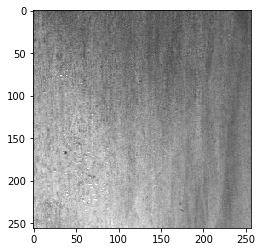

In [0]:
from matplotlib import pyplot as plt

plt.imshow(rs)

In [0]:
# assert X.shape[0] == Y.shape[0]
# datadict = dict()
# for i in range(5):
#     datadict[str(i)]=[]

# for data, label in tqdm(zip(X,Y)):
#   datadict[str(label)].append(data)

# plt.savefig('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/')

In [0]:
file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_0'
f = open(file_name, 'rb')
train_0 = pickle.load(f)
f.close()

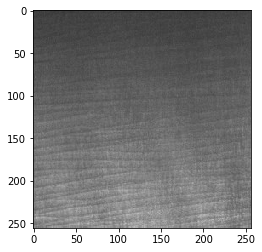

In [0]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# a = train_0[0].reshape(256,256,3)

# new_img = Image.fromarray(a , 'RGB')
# new_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/new_image.png')
# plt.imshow(a)

In [0]:
load_img = mpimg.imread("/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/new_image.png")
plt.imshow(load_img)

NameError: ignored

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for label in tqdm(range(5)):
  print(f'\n [INFO]... Loading label {str(label)}')
  file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_'+str(label)
  f = open(file_name, 'rb')
  train_pickle = pickle.load(f)
  f.close()
  
  print(f'\n No. of images found : {len(train_pickle)}')

  for i in tqdm(range(len(train_pickle))):   
    rs_img = train_pickle[i].reshape(256,256,3)
    array_img = Image.fromarray(rs_img, 'RGB')
    array_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/train/'+str(label)+'/'+str(i+1)+'.png')

  

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_4'
f = open(file_name, 'rb')
train_pickle = pickle.load(f)
f.close()

print(f'\n No. of images found : {len(train_pickle)}')

for i in tqdm(range(len(train_pickle))):   
  rs_img = train_pickle[i].reshape(256,256,3)
  array_img = Image.fromarray(rs_img, 'RGB')
  array_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/train/4/'+str(i+1)+'.png')

  

  0%|          | 4/971 [00:00<00:27, 34.76it/s]


 No. of images found : 971


100%|██████████| 971/971 [00:33<00:00, 29.21it/s]


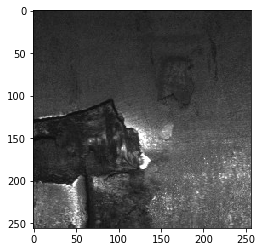

In [0]:
plt.imshow(train_pickle[970].reshape(256,256,3))

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for label in tqdm(range(5)):
  print(f'\n [INFO]... Loading label {str(label)}')
  file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_test_'+str(label)
  f = open(file_name, 'rb')
  test_pickle = pickle.load(f)
  f.close()
  
  print(f'\n No. of images found : {len(test_pickle)}')

  for i in tqdm(range(len(test_pickle))):   
    rs_img = test_pickle[i].reshape(256,256,3)
    array_img = Image.fromarray(rs_img, 'RGB')
    array_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/test/'+str(label)+'/'+str(i+1)+'.png')

  

In [3]:
cd /content/drive/My Drive/Kaggle/severstal-steel-old/saved_images

/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images


In [0]:
import keras
from keras.applications import ResNet101V2

img_height = 224
img_width = 224

base_model = ResNet101V2(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

In [0]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model

num_classes = 5

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x) 
preds = Dense(num_classes, activation= 'softmax')(x)

model = Model(inputs = base_model.input, outputs = preds)

In [0]:
# model.summary()

In [0]:
conv = 0
print("Total layers in ResNet101V2 : ", len(model.layers))

for i in range(len(model.layers)):
            if type(model.layers[i]) == keras.layers.convolutional.Conv2D:
                conv += 1
                
print("No. of Conv2D layers : ", conv)

Total layers in ResNet101V2 :  381
No. of Conv2D layers :  104


In [0]:
# set the base model to be not trainable

base_model.trainable = False

In [0]:
# validation split - 20 %
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 validation_split=0.2)

In [0]:
bs = 32                   #change batch size accordingly

CLASSES = ['0','1','2','3','4']

In [0]:
train_generator = train_datagen.flow_from_directory('train',  
                                                 target_size=(224,224),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training',
                                                 classes=CLASSES)

Found 21472 images belonging to 5 classes.


In [0]:
label_map = (train_generator.class_indices)
print("Label map: ",label_map)

Label map:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [0]:
val_generator=train_datagen.flow_from_directory('train', 
                                                 target_size=(224,224),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation',
                                                 classes=CLASSES)

Found 5367 images belonging to 5 classes.


In [0]:
step_size_train = (train_generator.n//train_generator.batch_size) + 1
print("Training step size: ",step_size_train)

step_size_val = (val_generator.n//val_generator.batch_size) + 1
print("Validation step size: ",step_size_val)

Training step size:  1342
Validation step size:  336


In [0]:
# SGD optimizer is used
from keras.optimizers import SGD

sgd = SGD()

model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['acc'])

In [0]:
from keras.callbacks import LearningRateScheduler
initial_epochs = 40       #change as per requirement

import math

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  drop_every = 5.0        #change as per requirement
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/drop_every))
  return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs,
                   callbacks = callbacks_list
                   )

# model.save('/content/drive/My Drive/xai_model/Severstal_RN101.h5')
# model.save_weights('.h5')

Epoch 1/40
1342/1342 [==============================] - 456s 340ms/step - loss: 0.6842 - acc: 0.7498 - val_loss: 0.6783 - val_acc: 0.7468
Epoch 2/40
1342/1342 [==============================] - 432s 322ms/step - loss: 0.5343 - acc: 0.8077 - val_loss: 0.6828 - val_acc: 0.7492
Epoch 3/40
1342/1342 [==============================] - 433s 323ms/step - loss: 0.4816 - acc: 0.8277 - val_loss: 0.5599 - val_acc: 0.8031
Epoch 4/40
1342/1342 [==============================] - 433s 323ms/step - loss: 0.4417 - acc: 0.8444 - val_loss: 0.4698 - val_acc: 0.8401
Epoch 5/40
1342/1342 [==============================] - 433s 323ms/step - loss: 0.3662 - acc: 0.8710 - val_loss: 0.4313 - val_acc: 0.8524
Epoch 6/40
1342/1342 [==============================] - 434s 324ms/step - loss: 0.3438 - acc: 0.8794 - val_loss: 0.3573 - val_acc: 0.8737
Epoch 7/40
1342/1342 [==============================] - 432s 322ms/step - loss: 0.3373 - acc: 0.8807 - val_loss: 0.4010 - val_acc: 0.8688
Epoch 8/40
1342/1342 [============

In [0]:
# model.save('.h5')
# model.save_weights('.h5')

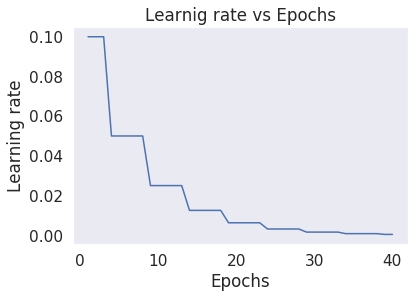

In [0]:
# plot the learning rate curve over epochs
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

x_axis = list(range(1,41))
y_axis = loss_history.lr
plt.plot(x_axis, y_axis)
plt.grid(None)
plt.title('Learnig rate vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
# plt.savefig('/content/drive/My Drive/xai_model/123.jpg')

In [0]:
# evaluating the model

scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

336/336 [==============================] - 85s 252ms/step
Validating loss: 0.32408831200734384
Validating accuracy: 0.8977082168920448


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

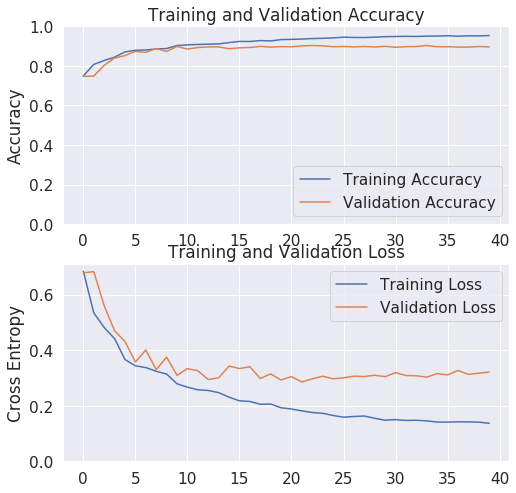

In [0]:
# plot the training and validation process' accuracy and loss

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
# plt.savefig('/content/drive/My Drive/xai_model/456.jpg')
plt.show()

In [0]:
from keras.preprocessing.image import  ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [62]:
bs_test = 32           #change test batch size here

test_generator = test_datagen.flow_from_directory('test',
                                                  target_size=(224,224),     
                                                  batch_size=bs_test,
                                                  class_mode='categorical',
                                                  shuffle = False)

Found 11505 images belonging to 5 classes.


In [63]:
step_size_test = (test_generator.n//test_generator.batch_size)+1
print("Test step size : ", step_size_test)
test_generator.reset()

Test step size :  360


In [64]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

360/360 [==============================] - 370s 1s/step


In [0]:
misclassified_list = []
false_labels = []
predIndx = np.argmax(predIndxs, axis=1).astype('int')

for i in range(test_generator.labels.shape[0]):
  if test_generator.labels[i] == 2 and predIndx[i] != 2:
    misclassified_list.append(test_generator.filepaths[i])
    false_labels.append(predIndx[i])
  else:
    continue

In [25]:
print(misclassified_list)
print(false_labels)

['test/2/1.png', 'test/2/10.png', 'test/2/13.png', 'test/2/15.png', 'test/2/21.png', 'test/2/25.png', 'test/2/26.png', 'test/2/27.png', 'test/2/28.png', 'test/2/34.png', 'test/2/38.png', 'test/2/41.png', 'test/2/44.png', 'test/2/46.png', 'test/2/48.png', 'test/2/52.png', 'test/2/55.png', 'test/2/7.png']
[0, 3, 3, 0, 0, 0, 3, 0, 3, 1, 1, 0, 0, 0, 3, 3, 3, 3]


In [55]:
misclassified_list[0]

'test/2/1.png'

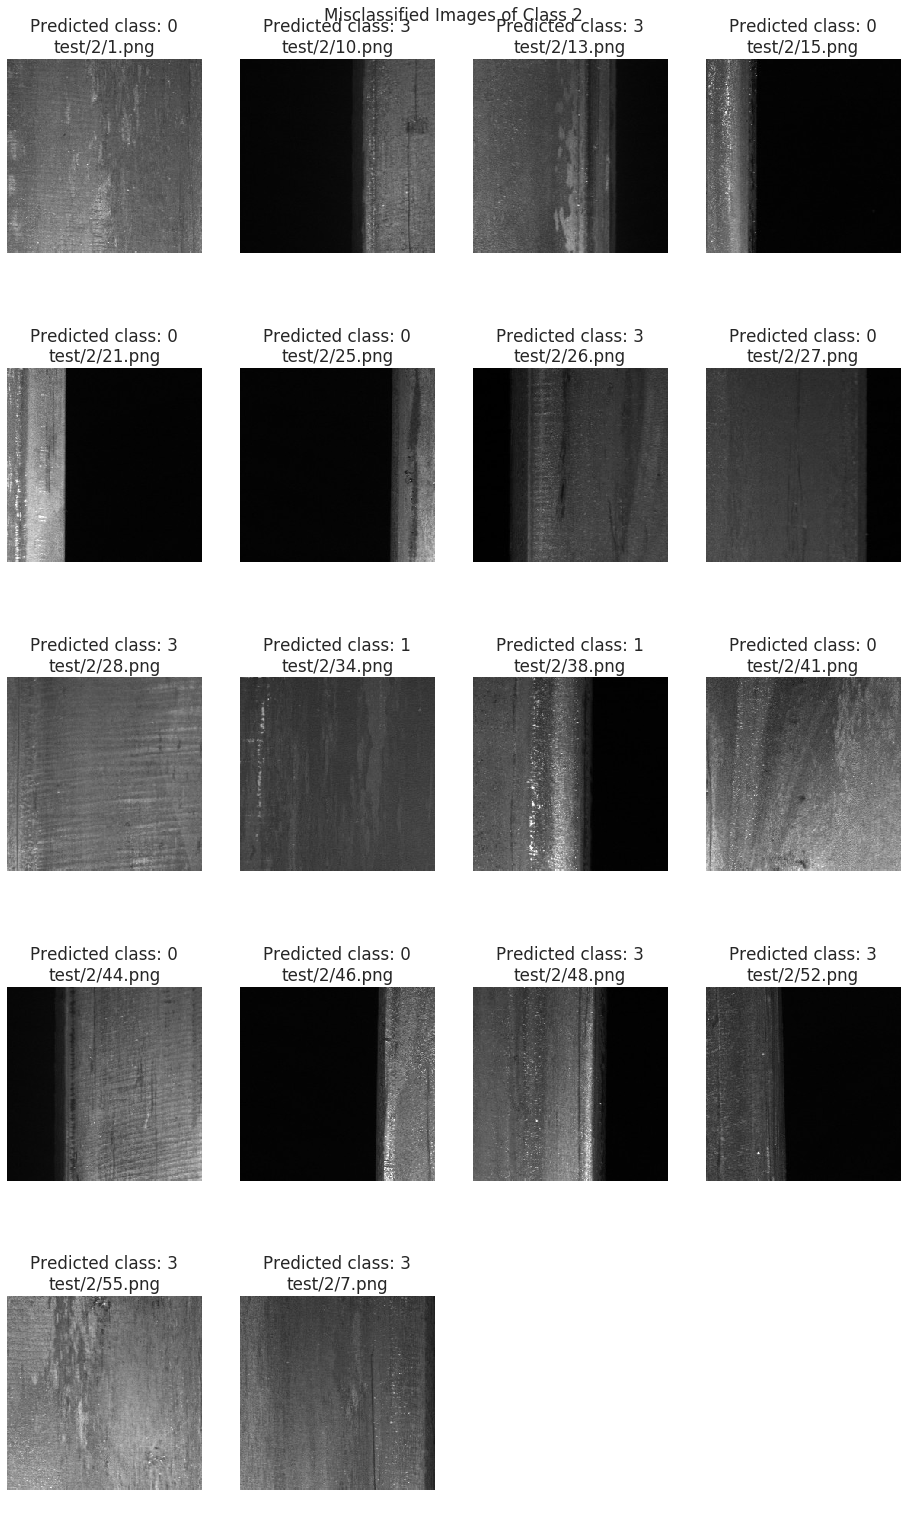

In [60]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
from math import ceil

columns = 4
rows = ceil(len(misclassified_list)/columns)
fig = plt.figure(figsize=(4*columns,5.5*rows))
plt.title("Misclassified Images of Class 2")
plt.axis('off')
for index in range(len(misclassified_list)):
  ax = fig.add_subplot(rows, columns, index+1)
  ax.axis('off')
  ax.imshow(image.load_img(misclassified_list[index]))
  title_1 = "Predicted class: {}".format(false_labels[index])
  title_2 = str(misclassified_list[index])
  ax.set_title(title_1+'\n'+title_2)
  plt.grid(False)

# plt.savefig("/content/drive/My Drive/XAI_results/Misclassified_2_LG.png")

In [27]:
acc_o = np.sum(np.argmax(predIndxs, axis=1).astype('int') == test_generator.labels) / test_generator.n
print("Test Accuracy : ",acc_o)

Test Accuracy :  0.9009126466753585


In [28]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

predIndxs_max = np.argmax(predIndxs, axis=1)
print(classification_report(test_generator.classes, predIndxs_max, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7124
           1       0.79      0.77      0.78       401
           2       0.80      0.71      0.76        63
           3       0.88      0.86      0.87      3500
           4       0.88      0.81      0.84       417

    accuracy                           0.90     11505
   macro avg       0.85      0.82      0.83     11505
weighted avg       0.90      0.90      0.90     11505



In [29]:
print('Confusion matrix:')
cm = confusion_matrix(test_generator.classes,predIndxs_max)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

Confusion matrix:
[[6673   55    5  351   40]
 [  66  309    3   21    2]
 [   8    2   45    8    0]
 [ 467   24    3 3000    6]
 [  54    2    0   23  338]]
Total test images:  11505
Accuracy: 0.901
Lables:
x axis: Predicted
y axis: Actual


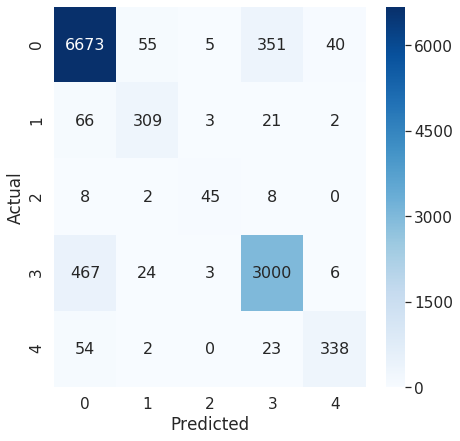

In [30]:
import seaborn as sn
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")
# plt.savefig('/content/drive/My Drive/xai_model/789.jpg')

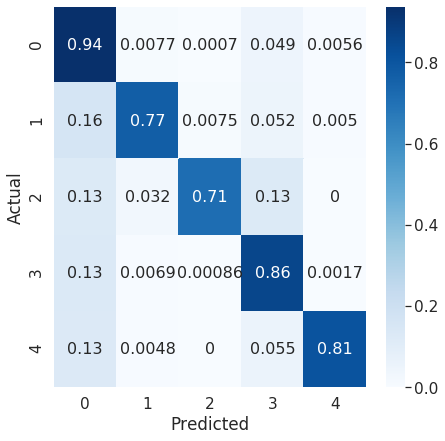

In [31]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt_cm = pd.DataFrame(cm_normalized, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
# plt.savefig('/content/drive/My Drive/xai_model/741.jpg')

In [0]:
# prediction

In [4]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/xai_model/Severstal_RN101.h5')

Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import os
import cv2
import numpy as np
import keras.backend as K
from keras.layers import Conv2D

def read_batch(img_dir, batch_names, batch_sz, sz):
    img_batch = np.empty((batch_sz, sz[0], sz[1], 3), dtype='uint8')
    for i in range(batch_sz):
        tmp = cv2.imread(os.path.join(img_dir, batch_names[i]))
        img_batch[i] = cv2.resize(tmp, (sz[0], sz[1]))
    return img_batch

def get_grad_cam_weights(input_model, dummy_image, should_normalize=True):
    def find_final_layer(model):
        for iter_layer, layer in reversed(list(enumerate(model.layers))):
            if type(layer) == Conv2D:
                return model.layers[iter_layer].name
        raise Exception('Could not find the final layer in provided network')

    # conv_layers = []
    # for i in range(len(saved_model.layers)):
    #   if type(saved_model.layers[i]) == Conv2D:
    #     conv_layers.append(saved_model.layers[i].name)

    # mid_layer_idx = len(conv_layers) / 2
    # mid_layer = conv_layers[int(mid_layer_idx)]
    final_layer = find_final_layer(input_model)                       #uses final layer
    conv_output = input_model.get_layer(final_layer).output           #change here
    num_classes = input_model.output_shape[1]
    num_feats = int(conv_output.shape[-1])
    weights = np.zeros((num_feats, num_classes))

    def normalize(x):
        # utility function to normalize a tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

    for iter_class in range(input_model.output_shape[1]):
        y_c = input_model.layers[-1].output[0, iter_class]
        if should_normalize:
            grad = normalize(K.gradients(y_c, conv_output)[0])
        else:
            grad = K.gradients(y_c, conv_output)[0]
        grad_func = K.function([input_model.layers[0].input, K.learning_phase()], [conv_output, grad])
        conv_val, grad_val = grad_func([dummy_image, 0])
        conv_val, grad_val = conv_val[0], grad_val[0]
        weights[:, iter_class] = np.mean(grad_val, axis=(0, 1))
    return weights, final_layer                                         #change here

def grad_cam(input_model, weights, images, is_pass_threshold, final_layer, conf_scores, orig_sz=[224, 224],
             should_upsample=False):
    conv_output = input_model.get_layer(final_layer).output  # activation_7
    conv_func = K.function([input_model.layers[0].input], [conv_output])
    conv_val = conv_func([images])
    conv_val = conv_val[0]
    cams = np.einsum('ijkl,lm->ijkm', conv_val, weights)
    if should_upsample:
        old_cams = cams[:]
        cams = np.zeros((old_cams.shape[0], orig_sz[0], orig_sz[1], old_cams.shape[-1]))
        for i in range(cams.shape[0]):
            for j in range(cams.shape[-1]):
                # cams[i, :, :, j] = cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1]))
                cams[i, :, :, j] = np.maximum(cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1])), 0)
    should_normalize = False
    if should_normalize:
        cams = cams / np.maximum(np.max(cams, axis=(1, 2, 3), keepdims=True), 1e-7)
        cams = cams * np.expand_dims(np.expand_dims(conf_scores * is_pass_threshold, axis=1), axis=2)
    else:
        cams = cams * np.expand_dims(np.expand_dims(is_pass_threshold, axis=1), axis=2)
    return cams

In [5]:
# conv_layers = []
# for i in range(len(saved_model.layers)):
#   if type(saved_model.layers[i]) == Conv2D:
#     conv_layers.append(saved_model.layers[i].name)

# mid_layer_idx = len(conv_layers) / 2
# mid_layer = conv_layers[int(mid_layer_idx)]

# print(len(conv_layers))
# print(mid_layer)

104
conv4_block10_1_conv


In [42]:
conv_layers

['conv1_conv',
 'conv2_block1_1_conv',
 'conv2_block1_2_conv',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block2_1_conv',
 'conv2_block2_2_conv',
 'conv2_block2_3_conv',
 'conv2_block3_1_conv',
 'conv2_block3_2_conv',
 'conv2_block3_3_conv',
 'conv3_block1_1_conv',
 'conv3_block1_2_conv',
 'conv3_block1_0_conv',
 'conv3_block1_3_conv',
 'conv3_block2_1_conv',
 'conv3_block2_2_conv',
 'conv3_block2_3_conv',
 'conv3_block3_1_conv',
 'conv3_block3_2_conv',
 'conv3_block3_3_conv',
 'conv3_block4_1_conv',
 'conv3_block4_2_conv',
 'conv3_block4_3_conv',
 'conv4_block1_1_conv',
 'conv4_block1_2_conv',
 'conv4_block1_0_conv',
 'conv4_block1_3_conv',
 'conv4_block2_1_conv',
 'conv4_block2_2_conv',
 'conv4_block2_3_conv',
 'conv4_block3_1_conv',
 'conv4_block3_2_conv',
 'conv4_block3_3_conv',
 'conv4_block4_1_conv',
 'conv4_block4_2_conv',
 'conv4_block4_3_conv',
 'conv4_block5_1_conv',
 'conv4_block5_2_conv',
 'conv4_block5_3_conv',
 'conv4_block6_1_conv',
 'conv4_block6_2_conv',
 

In [0]:
CLASSES = ['0','1','2','3','4']

(2048, 5)
conv5_block3_3_conv


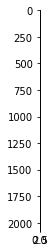

In [6]:
import matplotlib.pyplot as plt
alpha, layer = get_grad_cam_weights(saved_model, np.zeros((1, 224, 224, 3)))

print(alpha.shape)
plt.imshow(alpha)
print(layer)

[[8.8912890e-07 1.6712429e-06 9.9999607e-01 1.4424488e-06 1.4314676e-14]]
[2]
Output :  2


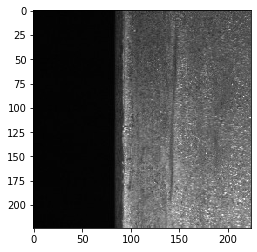

In [11]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

image_path = "/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/test/2/35.png"                #2/16      3/179

test_img_load = image.load_img(image_path, target_size=(224,224,3))
# plt.grid(None)
plt.imshow(test_img_load)

test_img = image.img_to_array(test_img_load)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

label_map =   {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
label_map_inv = {v:k  for k,v in label_map.items()}

result = saved_model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

Predicted label :  2


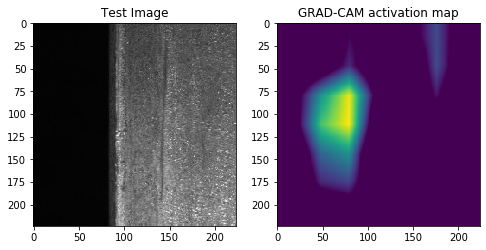

In [12]:
Y2 = grad_cam(saved_model, alpha, test_img, np.ones((len(test_img), len(CLASSES))), layer, result,
             orig_sz=test_img.shape[1:3], should_upsample=True)

print("Predicted label : ",output)

fig = plt.figure()
fig.set_size_inches(8, 6)
# plt.title("Class : "+str(CLASSES[int(prediction)]))
fig.add_subplot(1,2,1)
plt.title("Test Image")
plt.imshow(test_img_load)
fig.add_subplot(1,2,2)
plt.title("GRAD-CAM activation map")
plt.imshow(Y2[0, :, :, int(prediction)])

'2'